In [188]:
# Referência da aula: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-2-working-with-images-and-logistic-regression

## **Trabalhando com imagens**

Neste tutorial, usaremos nosso conhecimento existente de PyTorch e regressão linear para resolver um tipo de problema muito diferente: *classificação de imagens*. Usaremos o famoso [*Banco de dados de dígitos manuscritos MNIST*](http://yann.lecun.com/exdb/mnist/) como nosso conjunto de dados de treinamento. Consiste em imagens em escala de cinza de 28 por 28 pixels de dígitos manuscritos (0 a 9) e rótulos para cada imagem indicando qual dígito ela representa. Aqui estão alguns exemplos de imagens do conjunto de dados:

![mnist-amostra](https://i.imgur.com/CAYnuo1.jpg)

In [189]:
import torch
from torchvision.datasets import MNIST

In [190]:
dataset = MNIST(root='data/', download=True)

In [191]:
len(dataset)

60000

In [192]:
test_dataset = MNIST(root='data/', train=False)

In [193]:
len(test_dataset)

10000

In [194]:
dataset[0],test_dataset[0]

((<PIL.Image.Image image mode=L size=28x28>, 5),
 (<PIL.Image.Image image mode=L size=28x28>, 7))

In [195]:
import matplotlib.pyplot as plt
%matplotlib inline

Label 5


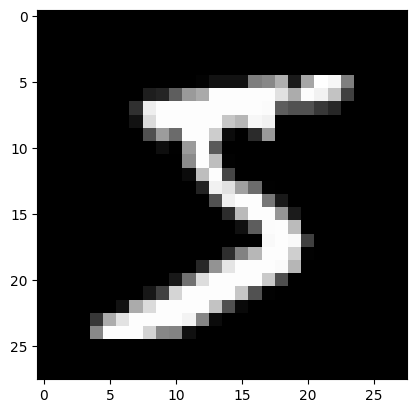

In [196]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label', label)

Label 0


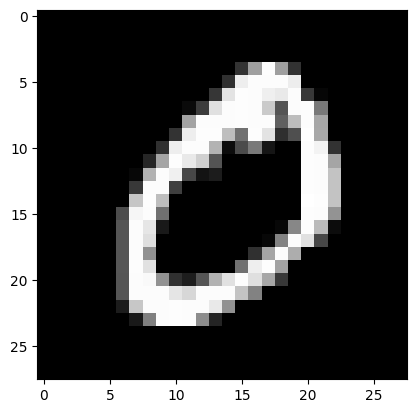

In [197]:
image, label = dataset[1]
plt.imshow(image, cmap='gray')
print('Label', label)

In [198]:
import torchvision.transforms as transforms

In [199]:
dataset = MNIST(root='data/',
                train=True,
                transform=transforms.ToTensor())

In [200]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


A imagem é agora convertida em um tensor 1x28x28. A primeira dimensão rastreia os canais de cores. A segunda e a terceira dimensões representam pixels ao longo da altura e da largura da imagem, respectivamente. Como as imagens no conjunto de dados MNIST são em escala de cinza, há apenas um canal. Outros conjuntos de dados têm imagens com cores e, nesse caso, há três canais: vermelho, verde e azul (RGB).

In [201]:
print(img_tensor[0,10:15, 10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


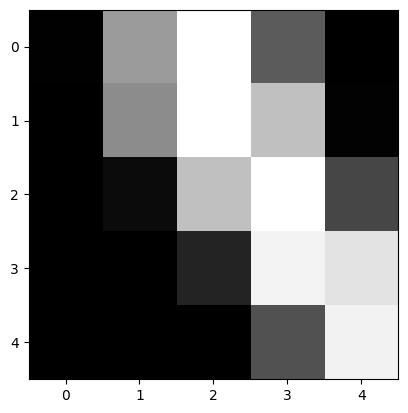

In [202]:
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray')

## **Conjuntos de dados de treinamento e validação**

Ao criar modelos de aprendizado de máquina no mundo real, é bastante comum dividir o conjunto de dados em três partes:

1. **Conjunto de treinamento** - usado para treinar o modelo, ou seja, calcular a perda e ajustar os pesos do modelo usando a descida de gradiente.
2. **Conjunto de validação** - usado para avaliar o modelo durante o treinamento, ajustar os hiperparâmetros (taxa de aprendizado, etc.) e escolher a melhor versão do modelo.
3. **Conjunto de teste** - usado para comparar diferentes modelos ou abordagens e informar a precisão final do modelo.

No conjunto de dados MNIST, há 60.000 imagens de treinamento e 10.000 imagens de teste. O conjunto de teste é padronizado para que diferentes pesquisadores possam relatar os resultados de seus modelos em relação à mesma coleção de imagens. 

Como não há um conjunto de validação predefinido, precisamos dividir manualmente as 60.000 imagens em conjuntos de dados de treinamento e validação. Vamos separar 10.000 imagens escolhidas aleatoriamente para validação. Podemos fazer isso usando o método `random_split` do PyTorch.

In [203]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

É essencial escolher uma amostra aleatória para criar um conjunto de validação. Os dados de treinamento geralmente são classificados pelos rótulos de destino, ou seja, imagens de 0s, seguidas de 1s, seguidas de 2s etc. Se criarmos um conjunto de validação usando os últimos 20% das imagens, ele consistirá apenas de 8s e 9s. Em contrapartida, o conjunto de treinamento não conteria 8s ou 9s. Esse tipo de treinamento-validação tornaria impossível treinar um modelo útil.

Agora podemos criar carregadores de dados para nos ajudar a carregar os dados em lotes. Usaremos um tamanho de lote de 128.

In [204]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

## **Criando o modelo**
Agora que preparamos nossos carregadores de dados, podemos definir nosso modelo.

* Um modelo de **regressão logística** é quase idêntico a um modelo de regressão linear. Ele contém pesos e matrizes de viés, e a saída é obtida usando operações simples de matriz (`pred = x @ w.t() + b`). 

* Assim como fizemos com a regressão linear, podemos usar o `nn.Linear` para criar o modelo em vez de criar e inicializar manualmente as matrizes.

* Como o `nn.Linear` espera que cada exemplo de treinamento seja um vetor, cada tensor de imagem `1x28x28` é _flattened_ em um vetor de tamanho 784 `(28*28)` antes de ser passado para o modelo. 

* A saída para cada imagem é um vetor de tamanho 10, com cada elemento significando a probabilidade de um rótulo de destino específico (ou seja, de 0 a 9). O rótulo previsto para uma imagem é simplesmente aquele com a maior probabilidade.

In [205]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

model = nn.Linear(input_size, num_classes)

In [206]:
model.weight.shape, model.weight

(torch.Size([10, 784]),
 Parameter containing:
 tensor([[ 2.2129e-02, -7.3956e-03, -1.7084e-02,  ..., -6.9460e-03,
          -3.3315e-02,  9.2212e-04],
         [ 5.9417e-03, -1.0100e-02, -2.0863e-03,  ...,  4.0055e-04,
           6.0371e-03,  1.1948e-02],
         [-3.5648e-03,  1.6514e-02, -7.7092e-03,  ...,  2.6717e-02,
          -2.7930e-02, -5.3164e-03],
         ...,
         [ 1.8826e-02, -2.4494e-02,  8.3286e-05,  ..., -2.5989e-02,
          -2.3851e-02,  3.4409e-02],
         [ 3.3169e-02, -1.8940e-02, -1.7162e-02,  ...,  1.7868e-02,
           3.3420e-02, -1.1502e-02],
         [ 2.6941e-02,  1.7888e-02,  1.0134e-02,  ..., -1.6317e-03,
           1.7583e-02, -2.2416e-02]], requires_grad=True))

In [207]:
model.bias.shape, model.bias

(torch.Size([10]),
 Parameter containing:
 tensor([ 0.0236,  0.0244, -0.0073,  0.0247,  0.0109,  0.0118, -0.0026, -0.0093,
          0.0046,  0.0321], requires_grad=True))

In [208]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    # xb neste caso é um batch
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

model = MnistModel()

Dentro do método construtor `__init__`, instanciamos os pesos e as tendências usando `nn.Linear`. E dentro do método `forward`, que é invocado quando passamos um lote de entradas para o modelo, achatamos o tensor de entrada e o passamos para `self.linear`.

O método `xb.reshape(-1, 28*28)` indica ao PyTorch que queremos uma *visão* do tensor `xb` com duas dimensões. O comprimento ao longo da segunda dimensão é 28\*28 (ou seja, 784). Um argumento para `.reshape` pode ser definido como `-1` (nesse caso, a primeira dimensão) para permitir que o PyTorch calcule automaticamente com base na forma do tensor original.

Observe que o modelo não tem mais os atributos `.weight` e `.bias` (pois agora eles estão dentro do atributo `.linear`), mas ele tem um método `.parameters` que retorna uma lista contendo os pesos e o bias.

In [209]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [210]:
model.linear.weight.shape, model.linear.bias.shape

(torch.Size([10, 784]), torch.Size([10]))

In [211]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0326,  0.0177,  0.0085,  ...,  0.0292,  0.0166,  0.0251],
         [ 0.0276,  0.0272, -0.0203,  ..., -0.0197,  0.0348,  0.0142],
         [-0.0139, -0.0093, -0.0061,  ...,  0.0174,  0.0083, -0.0295],
         ...,
         [ 0.0296, -0.0149, -0.0043,  ..., -0.0348,  0.0125, -0.0073],
         [ 0.0197, -0.0062, -0.0229,  ...,  0.0236, -0.0240,  0.0284],
         [ 0.0133, -0.0172,  0.0099,  ...,  0.0079, -0.0218,  0.0260]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0351,  0.0084,  0.0182, -0.0057, -0.0016, -0.0289,  0.0235,  0.0043,
          0.0313,  0.0063], requires_grad=True)]

In [212]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape', outputs.shape)
print('Sample outputs: \n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape torch.Size([128, 10])
Sample outputs: 
 tensor([[ 0.2443,  0.1384, -0.0427,  0.1835, -0.1210, -0.0995, -0.0463, -0.0392,
         -0.0176,  0.0206],
        [ 0.1064, -0.0376,  0.1277, -0.3161,  0.0952,  0.0745,  0.0752, -0.2796,
          0.0351,  0.1316]])


Para cada uma das 128 imagens de entrada, obtemos 10 saídas, uma para cada classe. Conforme discutido anteriormente, gostaríamos que esses resultados representassem probabilidades. Os elementos de cada linha de saída devem estar entre 0 e 1 e somar 1, o que não é o caso.

Para converter as linhas de saída em probabilidades, usamos a função softmax, que tem a seguinte fórmula:

![softmax](https://i.imgur.com/EAh9jLN.png)

Primeiro, substituímos cada elemento `yi` em uma linha de saída por `e^yi`, tornando todos os elementos positivos.

![](https://www.montereyinstitute.org/courses/DevelopmentalMath/COURSE_TEXT2_RESOURCE/U18_L1_T1_text_final_6_files/image001.png)



Em seguida, dividimos esses elementos por sua soma para garantir que eles somem 1. O vetor resultante pode, portanto, ser interpretado como probabilidades.

Embora seja fácil implementar a função softmax (você deveria tentar!), usaremos a implementação fornecida no PyTorch porque ela funciona bem com tensores multidimensionais (uma lista de linhas de saída no nosso caso).

In [213]:
import torch.nn.functional as F

In [214]:
outputs[:2]

tensor([[ 0.2443,  0.1384, -0.0427,  0.1835, -0.1210, -0.0995, -0.0463, -0.0392,
         -0.0176,  0.0206],
        [ 0.1064, -0.0376,  0.1277, -0.3161,  0.0952,  0.0745,  0.0752, -0.2796,
          0.0351,  0.1316]], grad_fn=<SliceBackward0>)

In [215]:
# Aplicando softmax para cada linha do output
probs = F.softmax(outputs, dim=1)

print("Sample probabilities:\n", probs[:2].data)
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.1240, 0.1115, 0.0931, 0.1167, 0.0861, 0.0879, 0.0927, 0.0934, 0.0954,
         0.0992],
        [0.1098, 0.0951, 0.1122, 0.0720, 0.1086, 0.1064, 0.1064, 0.0747, 0.1023,
         0.1126]])
Sum:  1.0000001192092896


Por fim, podemos determinar o rótulo previsto para cada imagem simplesmente escolhendo o índice do elemento com a maior probabilidade em cada linha de saída. Podemos fazer isso usando o `torch.max`, que retorna o maior elemento de cada linha e o índice correspondente.

In [216]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([0, 9, 5, 1, 7, 2, 6, 9, 7, 3, 2, 0, 9, 9, 1, 5, 1, 2, 2, 2, 2, 2, 1, 2,
        4, 9, 9, 8, 1, 2, 2, 1, 2, 2, 9, 2, 2, 9, 8, 2, 2, 2, 1, 2, 2, 1, 9, 2,
        2, 2, 6, 2, 0, 2, 8, 2, 2, 6, 4, 9, 2, 2, 6, 2, 8, 9, 9, 2, 2, 2, 1, 1,
        9, 6, 9, 2, 9, 9, 6, 2, 1, 8, 1, 2, 2, 2, 9, 2, 1, 9, 2, 2, 0, 2, 1, 2,
        9, 6, 9, 2, 8, 7, 9, 8, 6, 0, 3, 1, 8, 2, 9, 2, 1, 1, 2, 9, 2, 9, 8, 8,
        2, 2, 2, 2, 1, 2, 2, 2])
tensor([0.1240, 0.1126, 0.1237, 0.1169, 0.1099, 0.1266, 0.1482, 0.1409, 0.1225,
        0.1211, 0.1303, 0.1201, 0.1234, 0.1364, 0.1497, 0.1179, 0.1192, 0.1205,
        0.1203, 0.1224, 0.1223, 0.1415, 0.1415, 0.1185, 0.1208, 0.1370, 0.1388,
        0.1411, 0.1200, 0.1245, 0.1190, 0.1389, 0.1272, 0.1397, 0.1341, 0.1341,
        0.1174, 0.1444, 0.1206, 0.1396, 0.1221, 0.1277, 0.1364, 0.1328, 0.1271,
        0.1201, 0.1228, 0.1657, 0.1212, 0.1344, 0.1142, 0.1294, 0.1237, 0.1200,
        0.1132, 0.1361, 0.1450, 0.1101, 0.1279, 0.1215, 0.1290, 0.1190, 0.1142,
       

In [217]:
labels

tensor([7, 3, 0, 6, 6, 3, 7, 0, 9, 6, 8, 6, 5, 5, 4, 3, 4, 1, 2, 1, 7, 3, 4, 7,
        3, 0, 3, 0, 9, 4, 1, 4, 8, 0, 3, 9, 6, 0, 7, 6, 9, 8, 4, 2, 6, 6, 4, 8,
        6, 0, 7, 8, 7, 1, 6, 6, 8, 1, 5, 0, 8, 0, 5, 4, 3, 0, 0, 2, 0, 1, 6, 9,
        3, 9, 0, 6, 3, 0, 8, 7, 4, 5, 6, 6, 4, 3, 5, 8, 8, 3, 1, 1, 3, 3, 4, 9,
        7, 8, 3, 2, 9, 6, 3, 5, 9, 7, 5, 4, 6, 5, 5, 0, 6, 4, 5, 5, 5, 6, 2, 2,
        1, 6, 2, 0, 4, 6, 5, 5])

A maioria dos rótulos previstos é diferente dos rótulos reais. Isso se deve ao fato de termos começado com pesos e vieses inicializados aleatoriamente. Precisamos treinar o modelo, ou seja, ajustar os pesos usando a descida de gradiente para fazer previsões melhores.

# **Métrica de Avaliação e Função de Perda (Loss)**
Assim como na regressão linear, precisamos de uma maneira de avaliar o desempenho do nosso modelo. Uma maneira natural de fazer isso seria encontrar a porcentagem de rótulos que foram previstos corretamente, ou seja, a **precisão** das previsões.

In [218]:
outputs[:2]

tensor([[ 0.2443,  0.1384, -0.0427,  0.1835, -0.1210, -0.0995, -0.0463, -0.0392,
         -0.0176,  0.0206],
        [ 0.1064, -0.0376,  0.1277, -0.3161,  0.0952,  0.0745,  0.0752, -0.2796,
          0.0351,  0.1316]], grad_fn=<SliceBackward0>)

In [219]:
# Esta soma exibe quantas labels foram previstas corretamente pelo modelo
torch.sum(preds == labels)

tensor(5)

In [220]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

O operador `==` realiza uma comparação entre elementos de dois tensores com a mesma forma e retorna um tensor com a mesma forma, contendo `True` para elementos desiguais e `False` para elementos iguais. Passar o resultado para `torch.sum` retorna o número de rótulos que foram previstos corretamente. Por fim, dividimos pelo número total de imagens para obter a precisão.

Observe que não precisamos aplicar o softmax às saídas, pois seus resultados têm a mesma ordem relativa. Isso ocorre porque `e^x` é uma função crescente, ou seja, se `y1 > y2`, então `e^y1 > e^y2`. O mesmo acontece depois de calcular a média dos valores para obter o softmax.

Vamos calcular a precisão do modelo atual no primeiro lote de dados.

In [221]:
accuracy(outputs, labels)

tensor(0.0391)

In [222]:
probs

tensor([[0.1240, 0.1115, 0.0931,  ..., 0.0934, 0.0954, 0.0992],
        [0.1098, 0.0951, 0.1122,  ..., 0.0747, 0.1023, 0.1126],
        [0.0913, 0.0804, 0.1230,  ..., 0.0710, 0.1153, 0.1083],
        ...,
        [0.0894, 0.1135, 0.1252,  ..., 0.1176, 0.0923, 0.1040],
        [0.0804, 0.1061, 0.1373,  ..., 0.1125, 0.1223, 0.1020],
        [0.0712, 0.0856, 0.1252,  ..., 0.1180, 0.0917, 0.0970]],
       grad_fn=<SoftmaxBackward0>)

A acurácia é uma excelente forma para nós (humanos) avaliarmos o modelo. No entanto, não podemos usá-la como uma função de perda para otimizar nosso modelo usando gradiente descendente pelos seguintes motivos:

1. Não é uma função diferenciável. `torch.max` e `==` são operações não contínuas e não diferenciáveis, portanto, não podemos usar a precisão para calcular gradientes em relação aos pesos e vieses.

2. Não leva em consideração as probabilidades reais previstas pelo modelo, portanto não pode fornecer feedback suficiente para melhorias incrementais.

Por essas razões, a precisão é frequentemente usada como uma **métrica de avaliação** para classificação, mas não como uma função de perda. Uma função de perda comumente usada para problemas de classificação é a **entropia cruzada**, que tem a seguinte fórmula:

![entropia cruzada](https://i.imgur.com/VDRDl1D.png)

Embora pareça complicado, na verdade é bastante simples:

* Para cada linha de saída, escolha a probabilidade prevista para o rótulo correto. Por exemplo, se as probabilidades previstas para uma imagem forem `[0,1, 0,3, 0,2, ...]` e o rótulo correto for `1`, escolhemos o elemento correspondente `0,3` e ignoramos o resto.

* Em seguida, pegue o [logaritmo](https://en.wikipedia.org/wiki/Logarithm) da probabilidade escolhida. Se a probabilidade for alta, ou seja, próxima de 1, então seu logaritmo é um valor negativo muito pequeno, próximo de 0. E se a probabilidade for baixa (próxima de 0), então o logaritmo é um valor negativo muito grande. Também multiplicamos o resultado por -1, cujo resultado é um grande valor positivo de perda para previsões ruins.

![](https://www.intmath.com/blog/wp-content/images/2019/05/log10.png)

* Por fim, calcule a média da entropia cruzada em todas as linhas de saída para obter a perda geral de um lote de dados.

Ao contrário da precisão, a entropia cruzada é uma função contínua e diferenciável. Ele também fornece feedback útil para melhorias incrementais no modelo (uma probabilidade ligeiramente maior para o rótulo correto leva a uma perda menor). Esses dois fatores tornam a entropia cruzada uma escolha melhor para a função de perda.

Como você pode esperar, PyTorch fornece uma implementação de entropia cruzada eficiente e amigável ao tensor como parte do pacote `torch.nn.funcional`. Além disso, também executa softmax internamente, para que possamos passar diretamente as saídas do modelo sem convertê-las em probabilidades.

In [223]:
outputs

tensor([[ 0.2443,  0.1384, -0.0427,  ..., -0.0392, -0.0176,  0.0206],
        [ 0.1064, -0.0376,  0.1277,  ..., -0.2796,  0.0351,  0.1316],
        [-0.0357, -0.1631,  0.2626,  ..., -0.2871,  0.1981,  0.1354],
        ...,
        [-0.1045,  0.1341,  0.2319,  ...,  0.1692, -0.0726,  0.0462],
        [-0.2218,  0.0549,  0.3133,  ...,  0.1138,  0.1974,  0.0158],
        [-0.2771, -0.0929,  0.2879,  ...,  0.2285, -0.0234,  0.0322]],
       grad_fn=<AddmmBackward0>)

In [224]:
loss_fn = F.cross_entropy

In [225]:
# Perda para o lote atual de dados
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3500, grad_fn=<NllLossBackward0>)


Sabemos que a entropia cruzada é o logaritmo negativo da probabilidade prevista do rótulo correto calculado em média sobre todas as amostras de treinamento. Portanto, uma maneira de interpretar o número resultante, por ex. `2,23` é olhar para `e^-2,23` que é em torno de `0,1` como a probabilidade prevista do rótulo correto, em média. *Quanto menor for a perda, melhor será o modelo.*

# **Treinando o modelo**

Agora que definimos os carregadores de dados, modelo, função de perda e otimizador, estamos prontos para treinar o modelo. O processo de treinamento é idêntico à regressão linear, com o acréscimo de uma “fase de validação” para avaliar o modelo em cada época. Aqui está o que parece em pseudocódigo:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Algumas partes do ciclo de treinamento são específicas do problema que estamos resolvendo (por exemplo, função de perda, métricas etc.), enquanto outras são genéricas e podem ser aplicadas a qualquer problema de aprendizado profundo.

Incluiremos as partes independentes do problema em uma função chamada `fit`, que será usada para treinar o modelo. As partes específicas do problema serão implementadas adicionando novos métodos à classe `nn.Module`.

In [226]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = []
    
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        # Fase de validação  
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

A função `fit` registra a perda de validação e a métrica de cada época. Ele retorna um histórico do treinamento, útil para depuração e visualização.

Configurações como tamanho do lote, taxa de aprendizado, etc. (chamadas de hiperparâmetros) precisam ser escolhidas com antecedência durante o treinamento de modelos de aprendizado de máquina. A escolha dos hiperparâmetros corretos é fundamental para treinar um modelo razoavelmente preciso dentro de um período de tempo razoável. É uma área ativa de pesquisa e experimentação em aprendizado de máquina. Sinta-se à vontade para experimentar diferentes taxas de aprendizagem e ver como isso afeta o processo de treinamento.


Vamos definir a função `evaluate`, usada na fase de validação do `fit`.

In [227]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

Finalmente, vamos redefinir a classe `MnistModel` para incluir métodos adicionais `training_step`, `validation_step`, `validation_epoch_end` e `epoch_end` usados ​​por `fit` e `evaluate`.

In [228]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images) # Gerando previsões
        loss = F.cross_entropy(out, labels) # Calculando a perda
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Gerando previsões
        loss = F.cross_entropy(out, labels)    # Calculando a perda
        acc = accuracy(out, labels) # Calculando acurácia
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combinando perdas
        batch_ass = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_ass).mean()   # Combinando acurácias
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()} 
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        
model = MnistModel()

In [229]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.273984909057617, 'val_acc': 0.1252966821193695}

A precisão inicial é baixa, o que se poderia esperar de um modelo inicializado aleatoriamente.

Agora estamos prontos para treinar o modelo. Vamos treinar por cinco épocas e ver os resultados.

In [230]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9231, val_acc: 0.6373
Epoch [1], val_loss: 1.6614, val_acc: 0.7490
Epoch [2], val_loss: 1.4659, val_acc: 0.7732
Epoch [3], val_loss: 1.3183, val_acc: 0.7890
Epoch [4], val_loss: 1.2047, val_acc: 0.7998


Esse é um ótimo resultado! Com apenas 5 épocas de treinamento, nosso modelo atingiu uma precisão de mais de 80% no conjunto de validação. Vamos ver se podemos melhorar isso treinando por mais algumas épocas. Tentando alterar as taxas de aprendizagem e o número de épocas em cada uma das células abaixo.

In [231]:
history2 = fit(10, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1948, val_acc: 0.8007
Epoch [1], val_loss: 1.1852, val_acc: 0.8022
Epoch [2], val_loss: 1.1757, val_acc: 0.8032
Epoch [3], val_loss: 1.1665, val_acc: 0.8040
Epoch [4], val_loss: 1.1575, val_acc: 0.8046
Epoch [5], val_loss: 1.1487, val_acc: 0.8055
Epoch [6], val_loss: 1.1401, val_acc: 0.8060
Epoch [7], val_loss: 1.1317, val_acc: 0.8064
Epoch [8], val_loss: 1.1235, val_acc: 0.8074
Epoch [9], val_loss: 1.1154, val_acc: 0.8083


In [232]:
history3 = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0438, val_acc: 0.8149
Epoch [1], val_loss: 0.9851, val_acc: 0.8195
Epoch [2], val_loss: 0.9363, val_acc: 0.8232
Epoch [3], val_loss: 0.8950, val_acc: 0.8266
Epoch [4], val_loss: 0.8596, val_acc: 0.8302
Epoch [5], val_loss: 0.8290, val_acc: 0.8336
Epoch [6], val_loss: 0.8021, val_acc: 0.8365
Epoch [7], val_loss: 0.7784, val_acc: 0.8388
Epoch [8], val_loss: 0.7574, val_acc: 0.8406
Epoch [9], val_loss: 0.7384, val_acc: 0.8429


In [233]:
history4 = fit(20, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7214, val_acc: 0.8442
Epoch [1], val_loss: 0.7059, val_acc: 0.8452
Epoch [2], val_loss: 0.6918, val_acc: 0.8477
Epoch [3], val_loss: 0.6788, val_acc: 0.8492
Epoch [4], val_loss: 0.6669, val_acc: 0.8503
Epoch [5], val_loss: 0.6559, val_acc: 0.8514
Epoch [6], val_loss: 0.6457, val_acc: 0.8525
Epoch [7], val_loss: 0.6362, val_acc: 0.8536
Epoch [8], val_loss: 0.6274, val_acc: 0.8544
Epoch [9], val_loss: 0.6191, val_acc: 0.8551
Epoch [10], val_loss: 0.6114, val_acc: 0.8561
Epoch [11], val_loss: 0.6040, val_acc: 0.8573
Epoch [12], val_loss: 0.5972, val_acc: 0.8583
Epoch [13], val_loss: 0.5907, val_acc: 0.8595
Epoch [14], val_loss: 0.5845, val_acc: 0.8602
Epoch [15], val_loss: 0.5787, val_acc: 0.8610
Epoch [16], val_loss: 0.5732, val_acc: 0.8620
Epoch [17], val_loss: 0.5680, val_acc: 0.8629
Epoch [18], val_loss: 0.5630, val_acc: 0.8636
Epoch [19], val_loss: 0.5582, val_acc: 0.8642


Text(0.5, 1.0, 'Accuracy vs No. of Epochs')

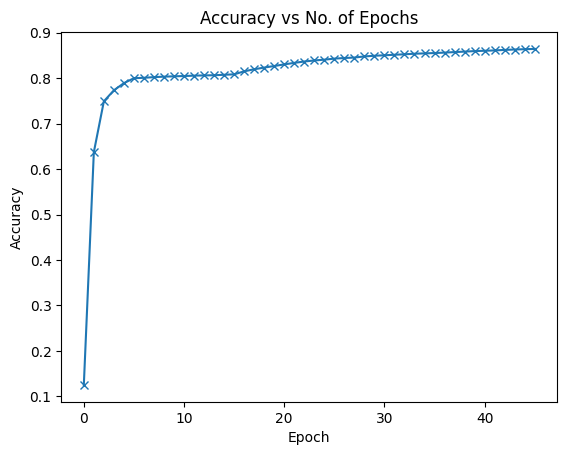

In [234]:
full_history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in full_history]
plt.plot(accuracies, '-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs No. of Epochs')

Fica bastante claro na imagem acima que o modelo provavelmente não ultrapassará o limite de precisão de 90%, mesmo após um treinamento por muito tempo. Uma possível razão para isso é que a taxa de aprendizagem pode ser muito alta. Os parâmetros do modelo podem estar “saltando” em torno do conjunto ideal de parâmetros para a perda mais baixa. Você pode tentar reduzir a taxa de aprendizado e treinamento por mais algumas épocas para ver se isso ajuda.

A razão mais provável é que **o modelo simplesmente não é poderoso o suficiente**. Se você se lembra de nossa hipótese inicial, assumimos que a saída (neste caso, as probabilidades da classe) é uma **função linear** da entrada (intensidades de pixel), obtida realizando uma multiplicação da matriz com a matriz de pesos e adicionando o viés. Esta é uma suposição bastante fraca, pois pode não existir realmente uma relação linear entre as intensidades dos pixels em uma imagem e o dígito que ela representa. Embora funcione razoavelmente bem para um conjunto de dados simples como o MNIST (levando-nos a 85% de precisão), precisamos de modelos mais sofisticados que possam capturar relações não lineares entre pixels de imagem e rótulos para tarefas complexas, como reconhecer objetos do cotidiano, animais, etc.

# **Treinando com Imagens Individuais**
Embora tenhamos acompanhado a precisão geral de um modelo até agora, também é uma boa ideia observar os resultados do modelo em algumas imagens de amostra. Vamos testar nosso modelo com algumas imagens do conjunto de dados de teste predefinido de 10.000 imagens. Começamos recriando o conjunto de dados de teste com a transformação `ToTensor`.

In [235]:
# Define test dataset
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


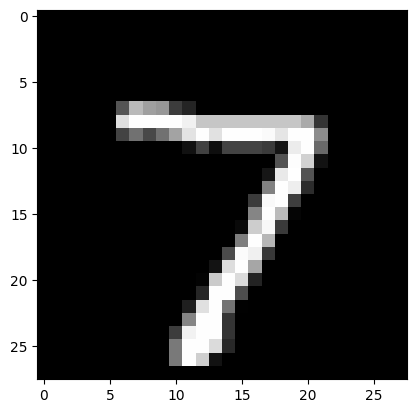

In [236]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [237]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

`img.unsqueeze` simplesmente adiciona outra dimensão no início do tensor 1x28x28, tornando-o um tensor 1x1x28x28, que o modelo vê como um lote contendo uma única imagem.

Vamos experimentar com algumas imagens.

Label: 7 , Predicted: 7


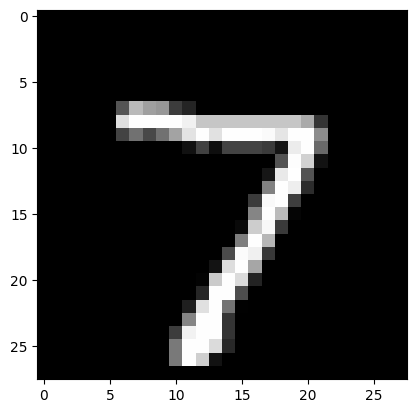

In [239]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


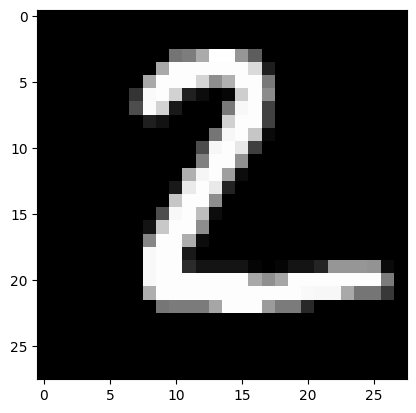

In [240]:
img, label = test_dataset[1]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 1 , Predicted: 1


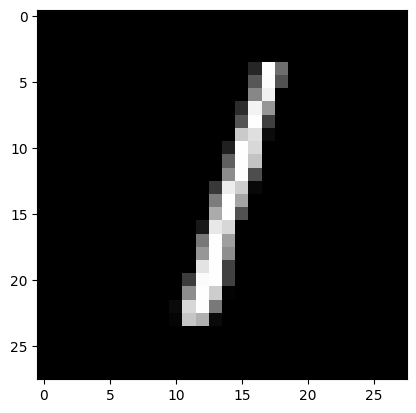

In [241]:
img, label = test_dataset[2]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 4


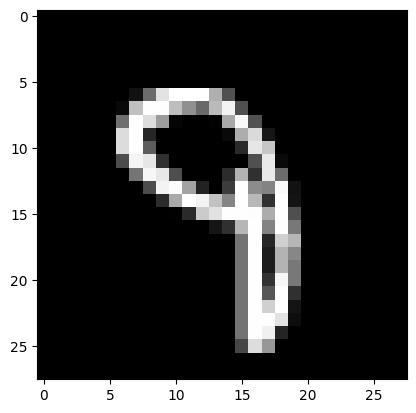

In [243]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


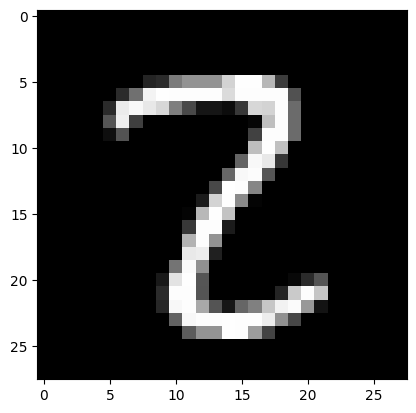

In [244]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identificar onde nosso modelo tem desempenho ruim pode nos ajudar a melhorá-lo, coletando mais dados de treinamento, aumentando/diminuindo a complexidade do modelo e alterando os hiperparâmetros.

Como etapa final, vejamos também a perda geral e a precisão do modelo no conjunto de teste.

In [245]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.5158073902130127, 'val_acc': 0.8753906488418579}

Esperamos que isso seja semelhante à precisão/perda no conjunto de validação. Caso contrário, poderemos precisar de um conjunto de validação melhor que tenha dados e distribuição semelhantes aos do conjunto de teste (que geralmente vem de dados do mundo real).

# **Treinando o modelo**
Como treinamos nosso modelo há muito tempo e alcançamos uma precisão razoável, seria uma boa ideia salvar os pesos e as matrizes de polarização em disco, para que possamos reutilizar o modelo posteriormente e evitar o retreinamento do zero. Veja como você pode salvar o modelo.

In [246]:
torch.save(model.state_dict(), 'mnist_logistic_regression.pth')

O método `.state_dict` retorna um `OrderedDict` contendo todos os pesos e matrizes de polarização mapeados para os atributos corretos do modelo.

In [247]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0172,  0.0083, -0.0352,  ..., -0.0336, -0.0003,  0.0153],
                      [ 0.0140,  0.0274,  0.0150,  ..., -0.0261,  0.0227, -0.0296],
                      [ 0.0071,  0.0236,  0.0212,  ..., -0.0316, -0.0290,  0.0290],
                      ...,
                      [ 0.0224,  0.0104,  0.0160,  ..., -0.0307, -0.0286, -0.0117],
                      [-0.0069, -0.0118,  0.0184,  ..., -0.0297, -0.0269, -0.0282],
                      [ 0.0171, -0.0049,  0.0114,  ..., -0.0257,  0.0023,  0.0189]])),
             ('linear.bias',
              tensor([-0.0563,  0.1531, -0.0048, -0.0504,  0.0583,  0.0523, -0.0131,  0.0862,
                      -0.1302,  0.0020]))])

Para carregar os pesos do modelo, podemos instantaneamente um novo objeto da classe `MnistModel`, e utilizar o método `.load_state_dict`.

In [248]:
model2 = MnistModel()

In [249]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0339, -0.0295, -0.0169,  ..., -0.0323,  0.0279, -0.0297],
                      [-0.0005, -0.0235,  0.0005,  ...,  0.0214,  0.0185, -0.0211],
                      [-0.0277,  0.0125,  0.0191,  ...,  0.0058, -0.0282, -0.0126],
                      ...,
                      [-0.0127,  0.0085, -0.0148,  ...,  0.0113,  0.0061, -0.0174],
                      [-0.0335, -0.0243,  0.0124,  ..., -0.0293, -0.0077, -0.0184],
                      [-0.0277,  0.0048, -0.0030,  ...,  0.0053,  0.0177,  0.0224]])),
             ('linear.bias',
              tensor([ 0.0081, -0.0334, -0.0072,  0.0303,  0.0137, -0.0142,  0.0112, -0.0010,
                       0.0176,  0.0282]))])

In [250]:
evaluate(model2, test_loader)

{'val_loss': 2.2846407890319824, 'val_acc': 0.14541015028953552}

In [258]:
model2.load_state_dict(torch.load('./mnist_logistic_regression.pth'))
model_state = model2.state_dict()
len(model_state['linear.weight'])

10

Apenas como uma verificação de integridade, vamos verificar se este modelo tem a mesma perda e precisão no conjunto de teste de antes.

In [254]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.5158073902130127, 'val_acc': 0.8753906488418579}